In [1]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/leodray/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leodray/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/leodray/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/leodray/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/leodray/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import pickle
from nltk import WordNetLemmatizer, PerceptronTagger, PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus.reader import wordnet
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import regex as re
from bs4 import BeautifulSoup

In [3]:
data = pd.read_csv('data/QueryV2.csv')

In [4]:
data.shape

(50000, 8)

In [5]:
data.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,12489,65,135968,21,9
1,Returning DataTables in WCF/.NET,<p>I have a WCF service from which I want to r...,<c#><.net><wcf><web-services><datatable>,12702,51,56176,12,8
2,What's the difference between struct and class...,<p>What's the difference between struct and cl...,<.net><class><struct><value-type><reference-type>,13049,830,453890,296,19
3,mysqli or PDO - what are the pros and cons?,<p>In our place we're split between using mysq...,<php><mysql><pdo><mysqli><database-abstraction>,13569,342,143841,284,13
4,Scrolling Overflowed DIVs with JavaScript,<p>I've got a div that uses overflow:auto to k...,<javascript><jquery><ajax><html><scroll>,13362,49,67437,10,6


In [6]:
data['Tags'].value_counts()

<javascript><jquery><html><css><twitter-bootstrap>                        28
<java><spring><jpa><spring-data><spring-data-jpa>                         22
<python><apache-spark><dataframe><pyspark><apache-spark-sql>              19
<python><image><opencv><image-processing><computer-vision>                15
<android><android-studio><gradle><android-gradle-plugin><build.gradle>    12
                                                                          ..
<javascript><html><transparent><tiles><isometric>                          1
<r><graph><visualization><hierarchical-data><ggplot2>                      1
<jquery><datetime><time><unix-timestamp><microtime>                        1
<haskell><functional-programming><lisp><scheme><currying>                  1
<java><android><database><sqlite><singleton>                               1
Name: Tags, Length: 48950, dtype: int64

In [7]:
stpwrds = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "A", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", "welcome", "well", "well-b", "went", "were", "weren", "werent", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", "whose", "why", "wi", "widely", "with", "within", "without", "wo", "won", "wonder", "wont", "would", "wouldn", "wouldnt", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz"]


def separate_code(text):
    pointer=text.find('<code>')
    result=''
    while pointer!=-1:
        ender=text.find(u'</code>',pointer)
        result=result+text[pointer+6:ender]
        pointer=text.find('<code>',ender)
    return result

  
def remove_code(text):
    pointer=text.find('<code>')
    while pointer!=-1:
        ender=text.find(u'</code>')
        text=text.replace(text[pointer:ender+7],' ')
        pointer=text.find('<code>')
    return text
def remove_html(text):
    return BeautifulSoup(text, 'lxml').get_text()


def letters_only(text):
    text=text.lower()
    text=re.sub("c\+\+","cplusplus", text)
    text=re.sub("c#","csharp", text)
    text=re.sub("\.net","dotnet", text)
    text=re.sub("d3\.js","d3js", text)
    text=re.sub("[^a-zA-Z]"," ", text)
    return text

  
def tokenize_body(text):
    text=word_tokenize(text)
    return text
  
  
lm = WordNetLemmatizer()

def wordnet_tag(tag):
        # Convert POS default tags to wordnet lemmatizer tags
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            # Default pos in lemmatization is Noun
            return wordnet.NOUN

tagger=PerceptronTagger()          
def postag_body(text):
    text=tagger.tag(text)
    return text
  
  
def lemm(text):
    for i,word in enumerate(text):
        text[i]=lm.lemmatize(word[0],pos=wordnet_tag(word[1]))
    return text
  
  
ps = PorterStemmer()

def stem(text):
    for word in text:
        word=ps.stem(word)
    return text
  
  
default_stopwords = set(stopwords.words('english'))
# The custom Stopwords list is a custom list built and curated manually after running a count vectorizer on the body a first time
#custom_stopwords = pickle.load( open( "../input/custom_stopwords.p", "rb" ) )
#stpwrds= default_stopwords.union(custom_stopwords)


def remove_stopwords(text):
    return [ w for w in text if not w in stpwrds]
  
  
def code_strip(text):
    text=text.strip(u'\n')
    text=text.lower()
    text=re.sub("[^a-zA-Z]"," ", text)
    return text
  
  
def tag_clean(text):
    text=re.sub("<","", text)
    text=re.sub(">"," ", text)
    return text
  
def body_join(text):
    text=' '.join(text)
    return text

In [8]:
data['Code']=data['Body'].apply(separate_code).apply(code_strip)

In [9]:
data['Body']=data['Body'].apply(remove_code).apply(remove_html).apply(letters_only)

In [10]:
data['Body']=data['Body'].apply(tokenize_body)

In [11]:
data['Body']=data['Body'].apply(postag_body) #Nécessaire à la lemmatisation

In [12]:
data['Body']=data['Body'].apply(lemm)

In [13]:
data['Body']=data['Body'].apply(remove_stopwords).apply(body_join)

In [14]:
data['Title']=data['Title'].apply(letters_only)

In [15]:
data['Title']=data['Title'].apply(tokenize_body)

In [16]:
data['Title']=data['Title'].apply(postag_body)

In [17]:
data['Title']=data['Title'].apply(lemm)

In [18]:
data['Title']=data['Title'].apply(remove_stopwords).apply(body_join)

In [19]:
data['Tags']=data['Tags'].apply(tag_clean)

In [20]:
data.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,Code
0,directory listing,scan directory folder file need cross platform,c file directory cross-platform common-tasks,12489,65,135968,21,9,
1,return datatables wcf dotnet,wcf service want return datatable know highly ...,c# .net wcf web-services datatable,12702,51,56176,12,8,datacontract public datatable gettbl ...
2,difference struct class dotnet,difference struct class dotnet,.net class struct value-type reference-type,13049,830,453890,296,19,
3,mysqli pdo pro,place split use mysqli pdo stuff prepared stat...,php mysql pdo mysqli database-abstraction,13569,342,143841,284,13,
4,scroll overflow divs javascript,div use overflow auto content inside div resiz...,javascript jquery ajax html scroll,13362,49,67437,10,6,thediv scrolltop thediv scrollhe...


# LDA

In [21]:
#CountVectorizer ?

In [22]:
title_vectorizer= CountVectorizer()
title_CV=title_vectorizer.fit_transform(data['Title'])
title_feature_names=title_vectorizer.get_feature_names()

/Users/leodray/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
no_dummytags = 100

lda_title = LatentDirichletAllocation(n_components=no_dummytags, max_iter=5, learning_method='online', learning_offset=50., n_jobs=4,random_state=0).fit(title_CV)

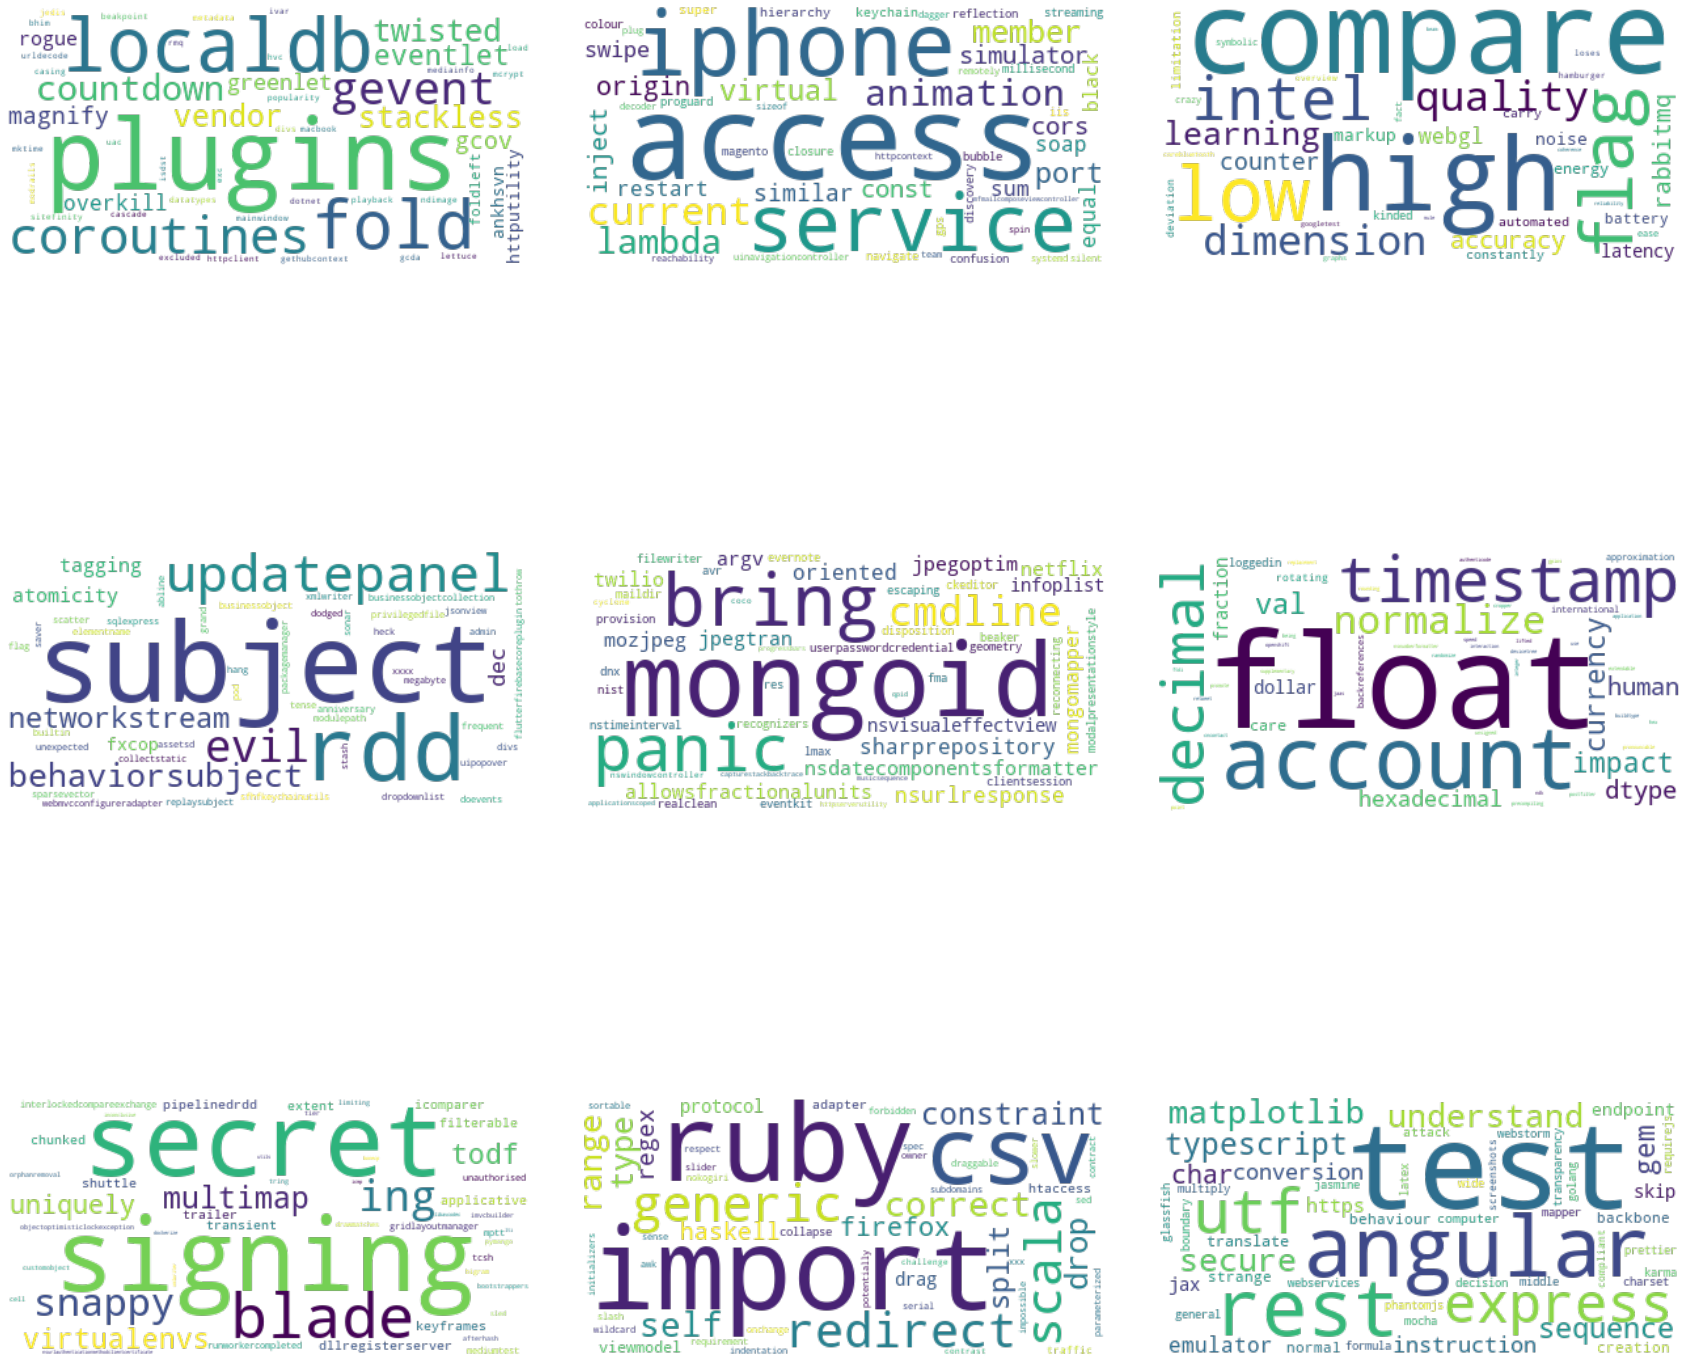

In [24]:
wordcloud = WordCloud(mode="RGBA", background_color=None, max_words=50)
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(hspace=0.01, wspace=0.1)
for k,topic in enumerate([6,10,21,23,24,28,39,51,58]):    
    freq={}
    for i,j in enumerate(lda_title.components_[topic]):
        freq[title_feature_names[i]]=j

    wordcloud.generate_from_frequencies(freq)
    sp=331+k
    plt.subplot(sp)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

In [25]:
# Sort the values in the TFIDF matrix in descending order
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
  
# Extract the top n words from each topic  
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

# Build a dictionary of topics' main features
        
def list_topics(model, feature_names, no_top_words):
    topic_dic={}
    for idx, topic in enumerate(model.components_):
        topic_dic[idx]=" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
    return topic_dic

In [26]:
title_vectorizer= TfidfVectorizer(sublinear_tf=True, min_df=0.001)

title_tfidf= title_vectorizer.fit_transform(data['Title'])

feature_names=title_vectorizer.get_feature_names()

title_topics= list_topics(lda_title, title_feature_names, 150)

title_tags=set()

for i in range(len(title_topics)):
  
    tf_idf_vector=title_vectorizer.transform([title_topics[i]])

    sorted_items=sort_coo(tf_idf_vector.tocoo())

    title_tags=title_tags.union(set(k for k in extract_topn_from_vector(feature_names,sorted_items,20)))

tag_vectorizer= CountVectorizer()
tag_CV=tag_vectorizer.fit_transform(data['Tags'])
tag_names=tag_vectorizer.get_feature_names()
    
    
print("\nNumber of Extracted Tags:")
print(len(title_tags))

print("\nTags found in both the extracted tags and the tag column of the dataset:")

cross_tags= [tag for tag in tag_names if tag in title_tags]
print(len(cross_tags))
print(sorted(cross_tags))


Number of Extracted Tags:
851

Tags found in both the extracted tags and the tag column of the dataset:
769
['abstract', 'accept', 'account', 'action', 'active', 'activity', 'add', 'address', 'admin', 'aggregate', 'ajax', 'algorithm', 'align', 'alternative', 'amazon', 'angular', 'angularjs', 'animate', 'animation', 'annotation', 'anonymous', 'apache', 'api', 'apk', 'app', 'append', 'apple', 'application', 'apply', 'apps', 'architecture', 'area', 'argument', 'array', 'arraylist', 'arrow', 'assembly', 'asset', 'assign', 'async', 'asynchronous', 'atomic', 'audio', 'authenticate', 'authorization', 'auto', 'autocomplete', 'automatic', 'await', 'aws', 'azure', 'backend', 'background', 'bad', 'bash', 'basic', 'batch', 'bean', 'behavior', 'big', 'binary', 'bind', 'binding', 'bitmap', 'blob', 'bluetooth', 'body', 'boolean', 'boost', 'boot', 'bootstrap', 'border', 'bound', 'box', 'branch', 'break', 'browser', 'buffer', 'bug', 'builder', 'building', 'bundle', 'byte', 'cache', 'callback', 'camera

# Preprocessing

In [27]:
#Utilisation CountVectorizer ?


------------------Top 20 tags:--------------------------


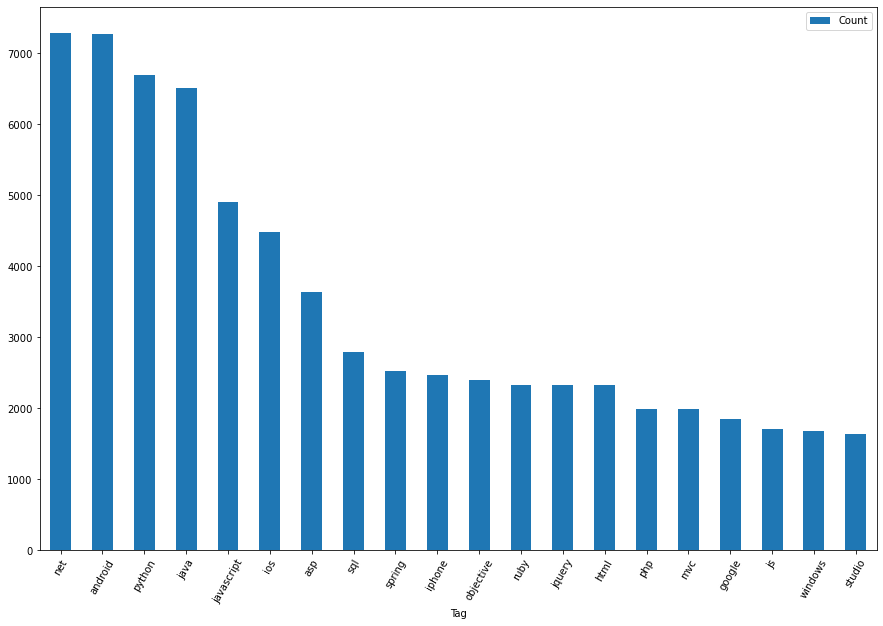

In [28]:
tag_vectorizer= CountVectorizer()
tag_CV=tag_vectorizer.fit_transform(data['Tags'])
tag_names=tag_vectorizer.get_feature_names()

# Sum up the counts of each vocabulary word
tag_CV=tag_CV.toarray()
dist = np.sum(tag_CV, axis=0)
sorted_counts=dist.argsort()
tags={}
for i in sorted_counts:
  tags[tag_names[i]]=dist[i]
tags_df=pd.DataFrame(columns=['Tag', 'Count'])
tags_df['Tag']=list(tags.keys())
tags_df['Count']=list(tags.values())
tags_df.sort_values(by=['Count'],ascending=False,inplace=True)
tags_df.shape

tags_df[0:20].plot.bar(x='Tag',y='Count',rot=60,figsize=(15,10))
print("\n------------------Top 20 tags:--------------------------")

In [29]:
def wrong_label_counter(y, y_pred):
  try:
    y=y.values
  except:
    pass
  diff = y - y_pred
  diff[diff==1]=0
  diff=np.abs(diff)
  diff=np.sum(diff,axis=1)
  size=y.shape[0]*y.shape[1]-np.count_nonzero(y)
  return 100*np.sum(diff)/size

def missed_label_counter(y, y_pred):
  try:
    y=y.values
  except:
    pass
  diff = y - y_pred
  diff[diff==-1]=0
  diff=np.abs(diff)
  diff=np.sum(diff,axis=1)
  size=np.count_nonzero(y)
  return 100*np.sum(diff)/size

In [30]:
#Utiliser MLB plutôt que get_dummies (inverse_transformer)

In [31]:
tag_set=set(tags_df.Tag[tags_df['Count']>200])

def select_tags(text):
    text=text.split()
    
    res = [t for t in text if t in tag_set]
    
    if res == []:
        return text
    else:
        return res

data['main_tags']=data['Tags'].copy(deep=True)

data['main_tags']=data['main_tags'].apply(select_tags)

data['main_tags']=data['main_tags'].apply(body_join)

In [32]:
data['main_tags']=data['main_tags'].apply(lambda x: x.split(' '))

In [33]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

Y = mlb.fit_transform(data['main_tags'])

In [49]:
data.main_tags

0                       [file, directory]
1                                   [wcf]
2                                 [class]
3                            [php, mysql]
4        [javascript, jquery, ajax, html]
                       ...               
49995                           [haskell]
49996                 [json, object, key]
49997                  [android, service]
49998                 [linux, excel, csv]
49999      [java, spring, hibernate, jpa]
Name: main_tags, Length: 50000, dtype: object

In [34]:
from sklearn.model_selection import train_test_split

data['full_text']=data['Title']+' '+data['Body']+' '+data['Code']

X_train, X_test, y_train, y_test= train_test_split(data, Y,test_size=0.2)

In [35]:
X_train.drop(['Title', 'Body', 'Tags', 'Id', 'Score', 'ViewCount', 'FavoriteCount', 'AnswerCount', 'Code', 'main_tags'], axis=1, inplace=True)

In [36]:
X_train

,full_text
16561,entity data model edmx template visual studio ...
36026,display time hour format objective work iphone...
45530,intellij idea persistence support spring boot ...
40730,implement method swizzling swift implement met...
34941,connection use curl command curl cacerts world...
...,...
45059,refresh view inside fragment search numerous q...
25253,mercurial revert version continue use mercuria...
7702,panda aws lambda numpy error code aws lambda i...
49575,use sql window command script control flow use...


In [37]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
#multi-label binarizer sklearn (fit_transform)

In [39]:
X_train

,full_text
16561,entity data model edmx template visual studio ...
36026,display time hour format objective work iphone...
45530,intellij idea persistence support spring boot ...
40730,implement method swizzling swift implement met...
34941,connection use curl command curl cacerts world...
...,...
45059,refresh view inside fragment search numerous q...
25253,mercurial revert version continue use mercuria...
7702,panda aws lambda numpy error code aws lambda i...
49575,use sql window command script control flow use...


In [40]:
X_train = X_train['full_text'].values

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [42]:
X_train['full_text'] = vectorizer.fit_transform(X_train['full_text'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [43]:
from lightgbm import LGBMClassifier

In [ ]:
X_train.shape

In [ ]:
y_train

In [44]:
from sklearn.pipeline import Pipeline

In [45]:
from sklearn.multiclass import OneVsRestClassifier

In [46]:
LGBM_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('lgbm', OneVsRestClassifier(LGBMClassifier(), n_jobs=1)),
            ])

In [47]:
LGBM_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('lgbm', OneVsRestClassifier(LGBMClassifier(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

NameError: name 'categories' is not defined

In [ ]:
labels = mlb.inverse_transform(y_train)

In [ ]:
l_labels = []
for labels in labels:
    for w in labels:
        if w not in l_labels:
            l_labels.append(w)
        

In [ ]:
lgbm = OneVsRestClassifier(LGBMClassifier(), n_jobs=1)

In [ ]:
for category in l_labels:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LGBM_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LGBM_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

In [ ]:
X_train = X_train.values

In [ ]:
y_train

In [ ]:
#light GBM

In [ ]:
X_test['full_text'] = vectorizer.transform(X_test['full_text'])

In [ ]:
X_test.drop(['Title', 'Body', 'Tags', 'Id', 'Score', 'ViewCount', 'FavoriteCount', 'AnswerCount', 'Code', 'main_tags'], axis=1, inplace=True)

In [ ]:
X_test.head()

In [ ]:
#utiliser inverse_transform sur les prédictions

# Bag of words

In [ ]:
#TF IDF pour vectoriser data['Full_text'] et data['main_tags'] puis LightGBM/RFC

In [ ]:
# Word2VEC

In [ ]:
#1 versus Rest pour sélection du modèle supervisé

# Sentence embedding

In [ ]:
#sentence transformer library python

In [ ]:
#BERT

In [ ]:
#USE

In [ ]:
#GLOVE

# Evaluation 

In [ ]:
#Méthodes d'évaluation et métriques --> Score jaccard car multi_label

In [ ]:
#Enregistrement de la pipeline de transformation et du modèle pour réemployer dans le code final à déployer

# Démonstration avec API

In [ ]:
#Stream lite ou Gradio